In [6]:
#Import of preprocessedText Data
import pandas as pd

df = pd.read_csv("PreprocessedText.csv")
df.head()

,doc_id,country,year,strategy_name,file_name,text,entities_ORG,entities_GPE,entities_PERSON,entities_NORP
0,CAN_2022,CAN,2022,Canada's National Quantum Strategy,CAN_2022_Canada's National Quantum Strategy.pdf,io executive summary advance quantum science p...,"['Next', 'The National Quantum Strategy', 'NQS...","['Canada', 'Quebec', 'Ontario', 'Alberta', 'Co...","['• De-risk', '• Identify', 'Mitacs', 'Creativ...","['Canadian', 'Canadians', 'Stakeholders', 'Bri..."
1,GER_2023,GER,2023,Quantum Technologies Conceptual Framework Prog...,GER_2023_Quantum Technologies Conceptual Frame...,1 exploit potential quantum technology germany...,"['Quantum', 'the Federal Government’s', 'quant...","['Germany', 'USA', 'China', 'Great Britain', '...","['A. Make', 'e. g.', 'Drive', 'BMBF', 'C. Crea...","['European', 'German', '→All', 'North American..."
2,UK_2023,UK,2023,National Quantum Strategy,UK_2023_National Quantum Strategy.pdf,ministerial foreword first generation quantum ...,"['Quantum', 'the Department for Science, Innov...","['UK', 'AI', 'Britain', 'US', 'South Wales', '...","['The Rt Hon Michelle Donelan', '• Drive', 'Pe...","['Canadian', 'European', 'Scottish', 'Launch']"
3,USA_2018,USA,2018,NATIONAL STRATEGIC OVERVIEW FOR QUANTUM INFO...,USA_2018_NATIONAL STRATEGIC OVERVIEW FOR QUAN...,lsn report 2017 operationalizing software defi...,"['LSN Report', 'USDA Department of Agriculture...","['the United States', 'U.S.', 'America', 'The ...","['Trump', 'Foster', '\uf0b7 Foster', 'Seek', '...","['American', 'Establish', 'Microsystems', 'Ame..."


In [7]:
# Creation of Dictionary and Corpus 
QH_DICT = {
    "government": [
        "government", "state", "public sector", "ministry", "agency",
        "regulation", "policy", "legislation", "governance",
        "public funding", "subsidy", "public procurement"
    ],
    "society": [
        "society", "civil society", "citizen", "public", "community",
        "ngo", "non profit", "foundation", "participation",
        "public engagement", "social impact", "trust"
    ],
    "industry": [
        "industry", "business", "private sector", "company", "firm",
        "enterprise", "startup", "sme", "corporation",
        "commercialization", "market", "value chain"
    ],
    "academia": [
        "academia", "academic", "university", "higher education",
        "research institution", "research", "scientific",
        "laboratory", "technology transfer"
    ]
}

In [8]:
import numpy as np
import pandas as pd
import re

# --- your QH_DICT must exist ---
# QH_DICT = {"government":[...], "society":[...], "industry":[...], "academia":[...]}

_token_re = re.compile(r"[a-z0-9]+(?:'[a-z0-9]+)?", re.IGNORECASE)

def tokenize(text: str):
    return _token_re.findall(str(text).lower())

def find_phrase_positions(tokens, phrase_tokens):
    positions = []
    n = len(phrase_tokens)
    if n == 0 or len(tokens) < n:
        return positions
    for i in range(len(tokens) - n + 1):
        if tokens[i:i+n] == phrase_tokens:
            positions.append(i)
    return positions

# Pre-tokenize dictionary phrases
dict_phrase_tokens = {
    cat: [tokenize(term) for term in terms]
    for cat, terms in QH_DICT.items()
}

def count_category_mentions(text: str):
    """Counts phrase occurrences per category in ONE document text."""
    tokens = tokenize(text)
    counts = {}
    for cat, phrase_tok_list in dict_phrase_tokens.items():
        c = 0
        for ptoks in phrase_tok_list:
            c += len(find_phrase_positions(tokens, ptoks))
        counts[cat] = c
    return counts

# --- per-document counts ---
qh_cols = list(QH_DICT.keys())

doc_counts = df["text"].apply(count_category_mentions).apply(pd.Series)
doc_counts = doc_counts.fillna(0).astype(int)

df_counts = pd.concat([df[["country", "year"]].copy(), doc_counts[qh_cols]], axis=1)

# --- aggregate per country/year ---
agg = (
    df_counts
    .groupby(["country", "year"], as_index=False)[qh_cols]
    .sum()
)

# shares (Actor-Share vector)
agg["total_mentions"] = agg[qh_cols].sum(axis=1)
for c in qh_cols:
    agg[f"share_{c}"] = np.where(agg["total_mentions"] > 0, agg[c] / agg["total_mentions"], 0.0)

share_cols = [f"share_{c}" for c in qh_cols]

agg = agg.sort_values(["country", "year"]).reset_index(drop=True)
agg["row_id"] = agg["country"].astype(str) + " — " + agg["year"].astype(str)

agg[["row_id"] + share_cols].head()


,row_id,share_government,share_society,share_industry,share_academia
0,CAN — 2022,0.280289,0.068716,0.343580,0.307414
1,GER — 2023,0.265823,0.115732,0.244123,0.374322
2,UK — 2023,0.215504,0.125581,0.390698,0.268217
3,USA — 2018,0.334286,0.091429,0.191429,0.382857


C:\Users\user\AppData\Local\Temp\ipykernel_22524\3905030134.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method="average")


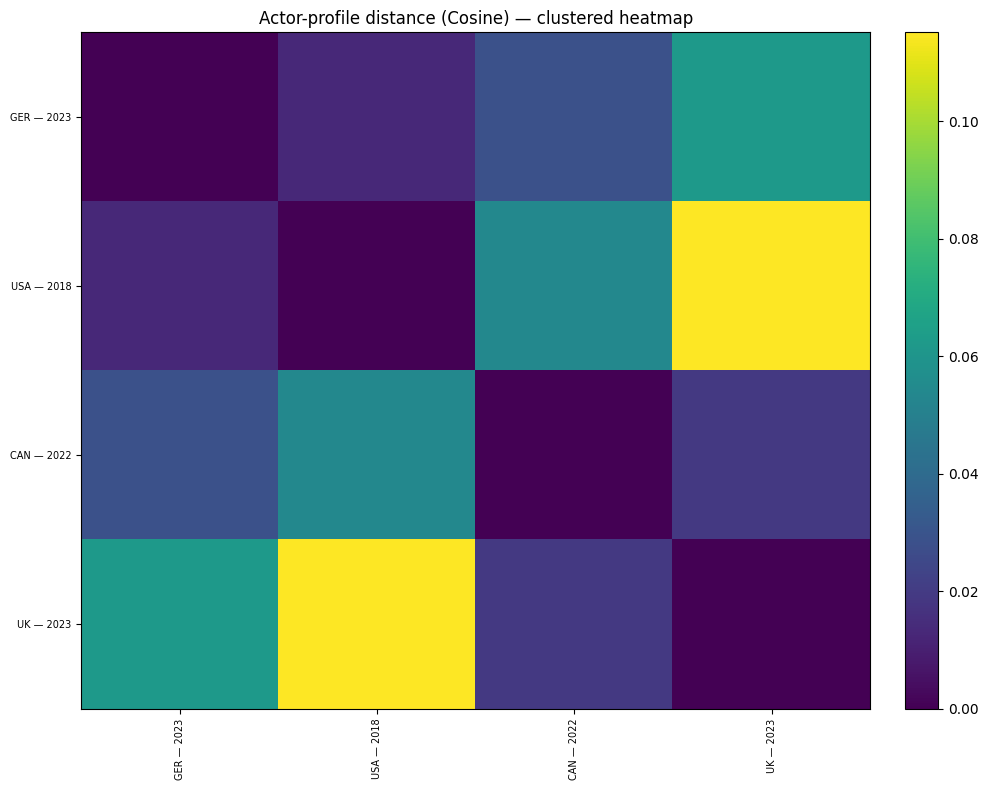

C:\Users\user\AppData\Local\Temp\ipykernel_22524\3905030134.py:17: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method="average")


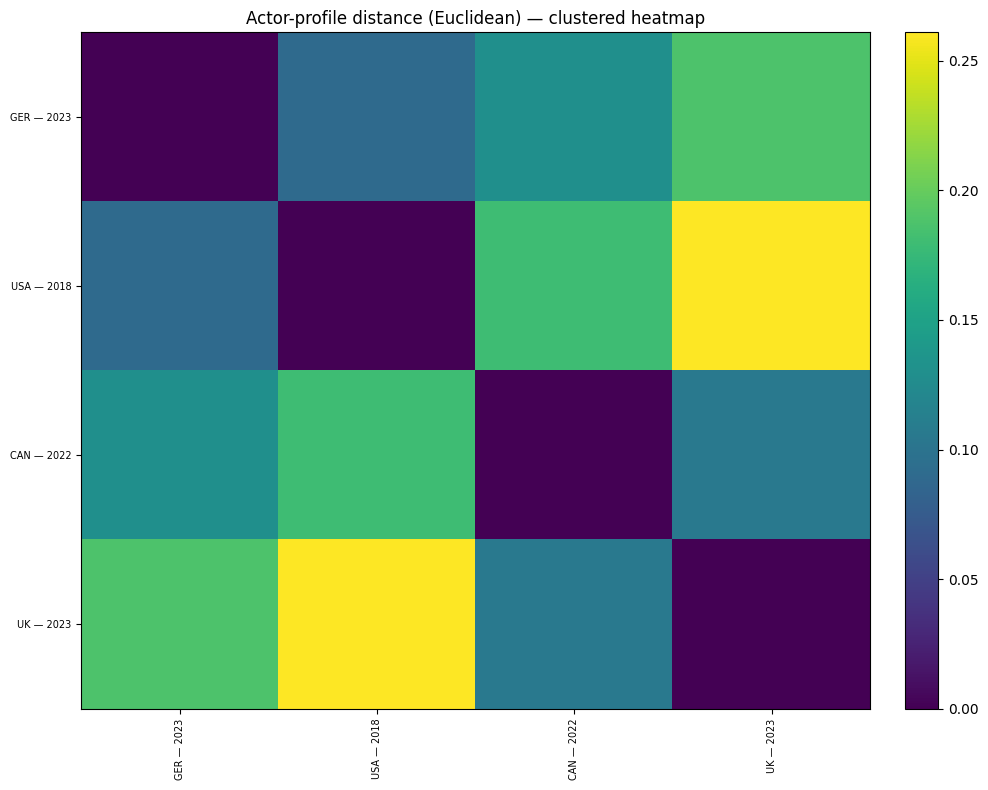

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from scipy.cluster.hierarchy import linkage, leaves_list

X = agg[share_cols].to_numpy()

# --- distances between rows (country/year profiles) ---
D_cos = cosine_distances(X)     # smaller = more similar
D_euc = euclidean_distances(X)

labels = agg["row_id"].tolist()

def clustered_heatmap(D, labels, title):
    # hierarchical clustering order (works nicely for heatmaps)
    Z = linkage(D, method="average")
    order = leaves_list(Z)

    D_ord = D[np.ix_(order, order)]
    labels_ord = [labels[i] for i in order]

    plt.figure(figsize=(10, 8))
    im = plt.imshow(D_ord, aspect="auto")
    plt.xticks(range(len(labels_ord)), labels_ord, rotation=90, fontsize=7)
    plt.yticks(range(len(labels_ord)), labels_ord, fontsize=7)
    plt.title(title)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

clustered_heatmap(D_cos, labels, "Actor-profile distance (Cosine) — clustered heatmap")
clustered_heatmap(D_euc, labels, "Actor-profile distance (Euclidean) — clustered heatmap")
